In [1]:
import os
import numpy as np
from langchain.agents import *
from langchain.llms import OpenAI
from dotenv import load_dotenv, find_dotenv
import torch
from langchain.document_loaders import PyPDFLoader, Docx2txtLoader, WikipediaLoader, TextLoader
from langchain import PromptTemplate

# Chains
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA
from langchain.chains.summarize import load_summarize_chain

#Vectorstore
import tiktoken
import pinecone 
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings, HuggingFaceInstructEmbeddings
#sql and json
from langchain.sql_database import SQLDatabase

#Agents
from langchain.agents import initialize_agent, Tool
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import PyPDFLoader, Docx2txtLoader, WikipediaLoader, TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

load_dotenv(find_dotenv(), override=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pinecone.init(api_key=os.environ.get("PINECONE_API_KEY"), environment=os.environ.get("PINECONE_ENV"))

D:\projects\venv\Lib\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Load Documents and vectorize
def val_load_llm_docs(file):
    name, extension = os.path.splitext(file)
    if extension == '.pdf':
        loader = PyPDFLoader(file)
    elif extension == '.docx':
        loader = Docx2txtLoader(file)
    elif extension == '.txt':
        loader = TextLoader(file, encoding='utf-8')
    else:
        return None
    data=loader.load()
    return data

def llm_load_from_wikipedia(query, lang='en', load_max_docs=2):
    loader = WikipediaLoader(query=query, lang=lang, load_max_docs=load_max_docs)
    data=loader.load()
    return data

# Text Splitter

def llm_chunk_data(data, chunk_size=10000):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=20)
    chunks = text_splitter.split_documents(data)
    return chunks

def llm_embeddings(hugh_embed, chunks, vector_dim=4096):
    
    index_name='vtoc'
    if index_name in pinecone.list_indexes():
        vector_store = Pinecone.from_existing_index(index_name,hugh_embed)
        #Pinecone.from_documents(documents=chunks, embedding=hug_embed, index_name=index_name)
    else:
        vector_store=FAISS.from_documents(chunks, hugh_embed)
        #vector_store = Chroma.from_documents(chunks, hugh_embed)
        pinecone.create_index(index_name, dimension=vector_dim, metric='cosine')
        Pinecone.from_documents(documents=chunks, embedding=hugh_embed, index_name=index_name) #dun=384. This is the class
    
    return vector_store


# OpenAI

In [2]:
# Get num tokens and generate text
llm=OpenAI(model_name='text-davinci-003', temperature=0, max_tokens=512)
first_query=['Describe SpaceX in one sentence', 'Describe Tesla Motors in one sentence']
num_tokens = llm.get_num_tokens(first_query[0])
first_ans = llm.generate(first_query)
print(num_tokens), print(first_ans.generations[1][0].text)

6


Tesla Motors is an American automotive and energy company that designs, manufactures, and sells electric vehicles, energy storage systems, and solar panels.


(None, None)

## Sequential Chains

In [15]:
# Prompt templates
planet_template = '''
You are a planetary research scientist. Write a 200 word summary about {planet}.
'''
planet_prompt = PromptTemplate(input_variables=['planet'], template=planet_template)
planet_ans = llm(planet_prompt.format(planet='Mars'))
planet_ans

'\nMars is the fourth planet from the Sun and the second-smallest planet in the Solar System. It is a terrestrial planet with a thin atmosphere composed primarily of carbon dioxide. It has a reddish hue due to the presence of iron oxide (rust) on its surface. Mars has two moons, Phobos and Deimos, which are small and irregularly shaped.\n\nMars has a number of features that make it an interesting target for exploration. It has the largest mountain in the Solar System, Olympus Mons, which is three times the height of Mount Everest. It also has the deepest and longest canyon in the Solar System, Valles Marineris. Mars also has evidence of past water activity, including dried-up riverbeds and lakebeds.\n\nMars is the only planet in the Solar System that has been explored by spacecraft. The first successful mission to Mars was the Mariner 4 spacecraft in 1965. Since then, numerous spacecraft have been sent to Mars, including the Viking landers, the Mars Pathfinder, and the Mars Exploration

In [17]:
# Simple Chains

planet_chain = LLMChain(llm=llm, prompt=planet_prompt)
planet_ans2 = planet_chain.run({'planet': 'Mars'})
planet_ans2

'\nMars is the fourth planet from the Sun and the second-smallest planet in the Solar System. It is a terrestrial planet with a thin atmosphere composed primarily of carbon dioxide. It has a reddish hue due to the presence of iron oxide (rust) on its surface. Mars has two moons, Phobos and Deimos, which are small and irregularly shaped.\n\nMars has a number of features that make it an interesting target for exploration. It has the largest mountain in the Solar System, Olympus Mons, which is three times the height of Mount Everest. It also has the deepest and longest canyon in the Solar System, Valles Marineris. Mars also has evidence of past water activity, including dried-up riverbeds and lakebeds.\n\nMars is the only planet in the Solar System that has been explored by spacecraft. The first successful mission to Mars was the Mariner 4 spacecraft in 1965. Since then, numerous spacecraft have been sent to Mars, including the Viking landers, the Mars Pathfinder, and the Mars Exploration

In [22]:
#Sequential Chains
planet_llm=OpenAI(model_name='text-davinci-003', temperature=0, max_tokens=1024)
moon_template = '''
You are a planetary research scientist. Given a planet {planet}, write a 200 word summary about its largest moon.
'''
moon_prompt = PromptTemplate(input_variables=['planet'], template=moon_template)
moon_chain = LLMChain(llm=llm, prompt=moon_prompt)
planetary_system_chain = SimpleSequentialChain(chains=[planet_chain, moon_chain], verbose=True)
planetary_system_chain.run('Jupiter')



> Entering new  chain...

Jupiter is the fifth planet from the Sun and the largest in the Solar System. It is a gas giant composed mostly of hydrogen and helium, with a mass two and a half times that of all the other planets combined. Jupiter has a strong magnetic field and is the most massive planet in the Solar System. It has a diameter of 142,984 km, making it 11 times wider than Earth.

Jupiter has a complex system of clouds and storms, including the Great Red Spot, a giant storm that has been raging for centuries. The planet has 79 known moons, the four largest of which are Io, Europa, Ganymede, and Callisto. These moons are believed to have formed from a collision between Jupiter and a large object in the early Solar System.

Jupiter's atmosphere is composed of mostly hydrogen and helium, with trace amounts of other elements. The planet's interior is believed to be composed of a rocky core surrounded by a layer of liquid metallic hydrogen. Jupiter's gravity is strong enough to 

"\nGanymede is the largest moon of Jupiter and the largest moon in the Solar System. It is the only moon known to have its own magnetic field. Ganymede is composed of a rocky core surrounded by an icy mantle and a thin atmosphere. It is believed to have formed from the collision of two objects in the early Solar System.\n\nGanymede is the only moon in the Solar System known to have its own magnetic field, which is generated by its core. This magnetic field protects Ganymede from the charged particles of Jupiter's magnetosphere. Ganymede is also the only moon known to have an atmosphere, which is composed of oxygen and other trace elements.\n\nGanymede is the most heavily cratered moon in the Solar System, with over 400 impact craters. Its surface is also covered with grooves and ridges, which are believed to be the result of tectonic activity. Ganymede is also home to a number of subsurface oceans, which may contain evidence of life beyond Earth.\n\nGanymede is an important part of the

## Wikipedia Agent

In [32]:
# Function which uses RetrievalQA
def val_llm_qa(vectorstore, llm, q, k=3):
    retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k', k})
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type='map_rank', retriever=retriever)
    ans = qa.run(q)
    return ans

def val_wiki_agents(tools, llm, q):
    agent_executor = initialize_agent(tools, llm, agent='zero-shot-react-description', verbose=True)
    ans = agent_executor.run(q)
    return ans

wiki=WikipediaAPIWrapper()
planet_tools = [Tool(name='Wikipedia', func=wiki.run, description='Get summary about topic from Wikipedia')]
query = 'Please provide a summary of the rocket Falcon 9'
val_wiki_agents(planet_tools, llm, planet_tools)



> Entering new  chain...
 This is a tool, so I need to use it to answer the question.
Action: Wikipedia
Action Input: The question I need to answer
Observation: Page: Phrases from The Hitchhiker's Guide to the Galaxy
Summary: The Hitchhiker's Guide to the Galaxy is a comic science fiction series created by Douglas Adams that has become popular among fans of the genre and members of the scientific community. Phrases from it are widely recognised and often used in reference to, but outside the context of, the source material. Many writers on popular science, such as Fred Alan Wolf, Paul Davies, and Michio Kaku, have used quotations in their books to illustrate facts about cosmology or philosophy.

Page: Question
Summary: A question is an utterance which serves as a request for information. Questions are sometimes distinguished from interrogatives, which are the grammatical forms typically used to express them. Rhetorical questions, for instance, are interrogative in form but may not be

'A research question is a question that a research project sets out to answer, and is usually narrow and specific. It is important to determine the type of study that will be conducted, such as a qualitative, quantitative, or mixed study, and additional factors such as project funding may affect the research question itself and when and how it is formed during the research process.'

# Huggingface

In [3]:
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain import HuggingFaceHub
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper

## Sequential Chains

In [5]:
# Prompt templates

flan_model_name="google/flan-t5-small"
planet_template = '''
You are a planetary research scientist. Write a summary about {planet}.
'''
planet_prompt = PromptTemplate(input_variables=['planet'], template=planet_template)
llm = HuggingFaceHub(repo_id=flan_model_name, model_kwargs={"temperature": 0.1, "max_length": 200})
llm_chain = LLMChain(prompt=planet_prompt, llm=llm)
question="Jupiter"
print(llm_chain.run(question))

D:\projects\venv\Lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


You are a scientist.


In [8]:
planet_chain = LLMChain(llm=llm, prompt=planet_prompt)
planet_ans2 = planet_chain.run({'planet': 'Mars'})
planet_ans2

'You are a planetary scientist.'

In [9]:
moon_template = '''
You are a planetary research scientist. Given a planet {planet}, write a brief 1000 character description summary about its largest moon. Include discussions about the moon's water and diameter
'''
moon_prompt = PromptTemplate(input_variables=['planet'], template=moon_template)
moon_chain = LLMChain(llm=llm, prompt=moon_prompt)
planetary_system_chain = SimpleSequentialChain(chains=[planet_chain, moon_chain], verbose=True)
planetary_system_chain.run('Jupiter')



> Entering new SimpleSequentialChain chain...
You are a scientist.
a planetary scientist

> Finished chain.


'a planetary scientist'

## Summarize Paper from Tokyo Tech Research

In [10]:
file='AutomaticaH2Aggregation4.pdf'
hug_embeddings = HuggingFaceEmbeddings()
val_file=val_load_llm_docs(file)
val_chunks = llm_chunk_data(val_file)
planet_vectorstore = llm_embeddings(hug_embeddings, val_chunks, vector_dim=386)
print(f'you have {len(val_file)} pages in the document')
print(f'you have {len(val_file[0].page_content)} characters in this page')
query="What possible applications does the model have"
jp=planet_vectorstore.similarity_search_with_score(query)
print(jp[0])

you have 13 pages in the document
you have 3684 characters in this page
(Document(page_content='state-space. Aggregating the cluster set under suitable\nweighting, we obtain a reduced model that preserves\ninterconnection topology among the clusters as well as\nsome speciﬁc properties, such as stability, steady-state\ncharacteristic and system positivity. Furthermore, we\nhave derived an H2-error bound of the state discrep-\nancy caused by the aggregation. In addition, applying\nthe proposed method to chemical reaction systems de-\nscribed by the chemical master equation, we have ob-\ntained a mesoscopic model that well approximates the\noriginal system as well as preserves speciﬁc properties\nas the chemical master equation.\nAcknowledgment\nThis research is partially supported by the Aihara Inno-\nvative Mathematical Modelling Project, the Japan So-\nciety for the Promotion of Science (JSPS) through the\n“Funding Program for World-Leading Innovative R&D\non Science and Technology (FI

## Inference Client to generate Image

In [3]:
from huggingface_hub import InferenceClient
client = InferenceClient()
image = client.text_to_image("Dystopian landscape, cyberpunk style, moon around gas giant")

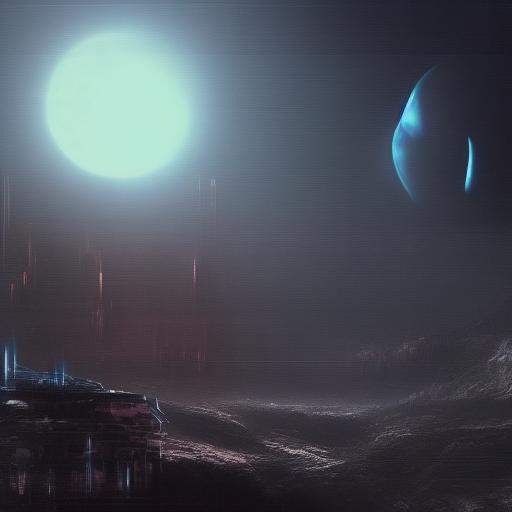

In [4]:
image

# LLama-2

In [4]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import LLMChain
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from ctransformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.llms import CTransformers

# Sentence Transform Embeddings
import tensorflow
from langchain.embeddings import LlamaCppEmbeddings
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory, FileChatMessageHistory 
from langchain.schema import SystemMessage
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.llms import HuggingFaceHub
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
import numpy as np
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig, LlamaForCausalLM
from datasets import load_dataset

llama_model_name="TheBloke/Llama-2-13B-Chat-GGUF"
llama_llm = CTransformers(
    model=llama_model_name, callbacks=[StreamingStdOutCallbackHandler()]
)

D:\projects\venv\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

## Sequential Chain

In [26]:

#llm = AutoModelForCausalLM.from_pretrained(llama_model_name, model_file="llama-2-7b-chat.q4_K_M.gguf", model_type="llama", gpu_layers=50)
# Prompt templates
planet_template = '''
You are a planetary research scientist. Write a 200 word summary about {planet}.
'''
planet_prompt = PromptTemplate(input_variables=['planet'], template=planet_template)
planet_chain = LLMChain(llm=llama_llm, prompt=planet_prompt)
planet_ans2 = planet_chain.run({'planet': 'Mars'})
moon_template = '''
You are a planetary research scientist. Given a planet {planet}, write a 200 word summary about its largest moon.
'''
moon_prompt = PromptTemplate(input_variables=['planet'], template=moon_template)
moon_chain = LLMChain(llm=llama_llm, prompt=moon_prompt)
planetary_system_chain = SimpleSequentialChain(chains=[planet_chain, moon_chain], verbose=True)
planetary_system_chain.run('Jupiter')

Mars is the fourth planet from the sun in the solar system and is known as the Red Planet due to its reddish appearance. The planet has a thin atmosphere made up of mostly carbon dioxide, with temperatures ranging from -125 degrees Celsius at night to 20 degrees Celsius during the day. Mars has two small moons, Phobos and Deimos, which are believed to be captured asteroids. The planet's surface is marked by numerous valleys, craters, and volcanoes, including the massive Olympus Mons, the largest volcano in the solar system. Mars has a complex geological history, with evidence of past water flow and potential for life. The planet's atmosphere is also home to methane, which could be a sign of microbial life. Ongoing research and exploration of Mars continues to uncover new insights into the planet's formation, evolution, and potential for habitability.

> Entering new SimpleSequentialChain chain...
Jupiter is the largest planet in our solar system, and is known for its massive size and p

"Jupiter's largest moon, Ganymede, is the largest moon in the solar system, even larger than the planet itself. With a diameter of approximately 3,200 miles (5,150 kilometers), Ganymede is the only moon in the solar system with its own substantial magnetic field. This field is powered by the friction caused by Ganymede's rotation and the gravitational interactions with Jupiter. The moon's surface features extensive ice deposits, including water ice, ammonia ice, and silicate minerals. The surface also hosts several impact craters, indicating a violent history of asteroid and comet impacts. Additionally, Ganymede has its own subsurface ocean, which is believed to be in contact with the moon's mantle. This liquid water could potentially support life, making Ganymede an exciting target for future astrobiology studies."

## Summarize Tokyo Tech Research

In [4]:
file='AutomaticaH2Aggregation4.pdf'
hug_embed = HuggingFaceEmbeddings()
val_file=val_load_llm_docs(file)
val_chunks = llm_chunk_data(val_file, chunk_size=500)
planet_vectorstore = llm_embeddings(hug_embed, val_chunks, vector_dim=768)
print(f'you have {len(val_file)} pages in the document')
print(f'you have {len(val_file[0].page_content)} characters in this page')
query="What possible applications does the model have"
jp=planet_vectorstore.similarity_search_with_score(query)
print(jp[0])

you have 13 pages in the document
you have 3684 characters in this page
(Document(page_content='Fourier model reduction. Automatica , 44-1:209–215, 2008.\n[19]S. Gugercin, A. C. Antoulas, and C. A. Beattie. H2model\nreduction for large-scale linear dynamical systems. SIAM\nJournal on Matrix Analysis and Applications , 30-2:609–638,\n2008.\n[20]S. Lall, P. Krysl, and J. E. Marsden. Structure-preserving\nmodel reduction for mechanical systems. Physica D:\nNonlinear Phenomena , 184-1-4:304–318, 2003.\n[21]R. C. Li and Z. Bai. Structure-preserving model reduction.', metadata={'source': 'C:/users/vtoci/Documents/Japan/Extra/AutomaticaH2Aggregation4.pdf', 'page': 11, 'text': 'Fourier model reduction. Automatica , 44-1:209–215, 2008.\n[19]S. Gugercin, A. C. Antoulas, and C. A. Beattie. H2model\nreduction for large-scale linear dynamical systems. SIAM\nJournal on Matrix Analysis and Applications , 30-2:609–638,\n2008.\n[20]S. Lall, P. Krysl, and J. E. Marsden. Structure-preserving\nmodel reduc

## Wikipedia Wrapper

In [ ]:
# Function which uses RetrievalQA
def val_llm_qa(vectorstore, llm, q, k=3):
    retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k', k})
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type='map_rank', retriever=retriever)
    ans = qa.run(q)
    return ans

def val_wiki_agents(tools, llm, q):
    agent_executor = initialize_agent(tools, llm, agent='zero-shot-react-description', verbose=True)
    ans = agent_executor.run(q)
    return ans

wiki=WikipediaAPIWrapper()
planet_tools = [Tool(name='Wikipedia', func=wiki.run, description='Get summary about topic from Wikipedia')]
query = 'Please provide a 200 word summary of the rocket Falcon 9'
val_wiki_agents(planet_tools, llama_llm, query)

## Conversation Chain

In [6]:
template = """

The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does
not know.

Current conversation:
Human: {input}
AI Assistant:"""
llama_llm = CTransformers(
    model=llama_model_name, callbacks=[StreamingStdOutCallbackHandler()]
)
llm_hug = HuggingFaceHub(repo_id=llama_model_name)
chat_history = FileChatMessageHistory('val_chat_history.json')
chat_memory = ConversationBufferMemory(memory_key='chat_history', chat_memory=chat_history, return_messages=True)
chat_prompt = ChatPromptTemplate.from_messages([SystemMessagePromptTemplate.from_template(template),
                              MessagesPlaceholder(variable_name='chat_history'),
                             HumanMessagePromptTemplate.from_template('{input}')])

llm_chat_chain=ConversationChain(llm=llama_llm, prompt=chat_prompt, memory=chat_memory, verbose=False)
while True:
    content=input('Your prompt: ')
    if content in ['exit', 'bye']:
        print('Goodbye')
        break
    response = llm_chat_chain.run({'input': content})
    print(response)
    print('-'*20)
    

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

D:\projects\venv\Lib\site-packages\huggingface_hub\utils\_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


Your prompt:  What's the capital of Romania?


Number of tokens (1348) exceeded maximum context length (512).
Number of tokens (1349) exceeded maximum context length (512).


Number of tokens (1350) exceeded maximum context length (512).


AI

Number of tokens (1351) exceeded maximum context length (512).


:

Number of tokens (1352) exceeded maximum context length (512).


Number of tokens (1353) exceeded maximum context length (512).


 is

Number of tokens (1354) exceeded maximum context length (512).


 in

Number of tokens (1355) exceeded maximum context length (512).


 W

Number of tokens (1356) exceeded maximum context length (512).


AS

Number of tokens (1357) exceeded maximum context length (512).


soci

Number of tokens (1358) exceeded maximum context length (512).


ety

Number of tokens (1359) exceeded maximum context length (512).


).

Number of tokens (1360) exceeded maximum context length (512).


 *

Number of tokens (1361) exceeded maximum context length (512).


is

Number of tokens (1362) exceeded maximum context length (512).


 there

Number of tokens (1363) exceeded maximum context length (512).


 is

Number of tokens (1364) exceeded maximum context length (512).


 known

Number of tokens (1365) exceeded maximum context length (512).


 for

Number of tokens (1366) exceeded maximum context length (512).


 me

Number of tokens (1367) exceeded maximum context length (512).


-

Number of tokens (1368) exceeded maximum context length (512).


related

Number of tokens (1369) exceeded maximum context length (512).


 to

Number of tokens (1370) exceeded maximum context length (512).


 be

Number of tokens (1371) exceeded maximum context length (512).


ars

Number of tokens (1372) exceeded maximum context length (512).


)

Number of tokens (1373) exceeded maximum context length (512).


 is

Number of tokens (1374) exceeded maximum context length (512).


 a

Number of tokens (1375) exceeded maximum context length (512).


ims

Number of tokens (1376) exceeded maximum context length (512).


 to

Number of tokens (1377) exceeded maximum context length (512).


 the

Number of tokens (1378) exceeded maximum context length (512).


 largest

Number of tokens (1379) exceeded maximum context length (512).


 city

Number of tokens (1380) exceeded maximum context length (512).


 has

Number of tokens (1381) exceeded maximum context length (512).


 been

Number of tokens (1382) exceeded maximum context length (512).


 through

Number of tokens (1383) exceeded maximum context length (512).


 history

Number of tokens (1384) exceeded maximum context length (512).


?

Number of tokens (1385) exceeded maximum context length (512).


Number of tokens (1386) exceeded maximum context length (512).


AI

Number of tokens (1387) exceeded maximum context length (512).


:

Number of tokens (1388) exceeded maximum context length (512).


 Can

Number of tokens (1389) exceeded maximum context length (512).


 you

Number of tokens (1390) exceeded maximum context length (512).


 would

Number of tokens (1391) exceeded maximum context length (512).


 you

Number of tokens (1392) exceeded maximum context length (512).


 would

Number of tokens (1393) exceeded maximum context length (512).


 you

Number of tokens (1394) exceeded maximum context length (512).


 would

Number of tokens (1395) exceeded maximum context length (512).


 you

Number of tokens (1396) exceeded maximum context length (512).


 would

Number of tokens (1397) exceeded maximum context length (512).


 you

Number of tokens (1398) exceeded maximum context length (512).


 are

Number of tokens (1399) exceeded maximum context length (512).


 we

Number of tokens (1400) exceeded maximum context length (512).


 call

Number of tokens (1401) exceeded maximum context length (512).


 themselves

Number of tokens (1402) exceeded maximum context length (512).


.

Number of tokens (1403) exceeded maximum context length (512).


 The

Number of tokens (1404) exceeded maximum context length (512).


 largest

Number of tokens (1405) exceeded maximum context length (512).


 cities

Number of tokens (1406) exceeded maximum context length (512).


 have

Number of tokens (1407) exceeded maximum context length (512).


 you

Number of tokens (1408) exceeded maximum context length (512).


 like

Number of tokens (1409) exceeded maximum context length (512).


 to

Number of tokens (1410) exceeded maximum context length (512).


 the

Number of tokens (1411) exceeded maximum context length (512).


 second

Number of tokens (1412) exceeded maximum context length (512).


 largest

Number of tokens (1413) exceeded maximum context length (512).


 cities

Number of tokens (1414) exceeded maximum context length (512).


 has

Number of tokens (1415) exceeded maximum context length (512).


 UN

Number of tokens (1416) exceeded maximum context length (512).


ES

Number of tokens (1417) exceeded maximum context length (512).


o

Number of tokens (1418) exceeded maximum context length (512).


ara

Number of tokens (1419) exceeded maximum context length (512).


).

Number of tokens (1420) exceeded maximum context length (512).


 It

Number of tokens (1421) exceeded maximum context length (512).


'

Number of tokens (1422) exceeded maximum context length (512).


s

Number of tokens (1423) exceeded maximum context length (512).


 third

Number of tokens (1424) exceeded maximum context length (512).


 largest

Number of tokens (1425) exceeded maximum context length (512).


 city

Number of tokens (1426) exceeded maximum context length (512).


 has

Number of tokens (1427) exceeded maximum context length (512).


 a

Number of tokens (1428) exceeded maximum context length (512).


 year

Number of tokens (1429) exceeded maximum context length (512).


 was

Number of tokens (1430) exceeded maximum context length (512).


 part

Number of tokens (1431) exceeded maximum context length (512).


 of

Number of tokens (1432) exceeded maximum context length (512).


 Roman

Number of tokens (1433) exceeded maximum context length (512).


ia

Number of tokens (1434) exceeded maximum context length (512).


'

Number of tokens (1435) exceeded maximum context length (512).


s

Number of tokens (1436) exceeded maximum context length (512).


 economy

Number of tokens (1437) exceeded maximum context length (512).


?

Number of tokens (1438) exceeded maximum context length (512).


Number of tokens (1439) exceeded maximum context length (512).


AI

Number of tokens (1440) exceeded maximum context length (512).


:

Number of tokens (1441) exceeded maximum context length (512).


Number of tokens (1442) exceeded maximum context length (512).


AI

Number of tokens (1443) exceeded maximum context length (512).


:

Number of tokens (1444) exceeded maximum context length (512).


Number of tokens (1445) exceeded maximum context length (512).


AI

Number of tokens (1446) exceeded maximum context length (512).


:

Number of tokens (1447) exceeded maximum context length (512).


Number of tokens (1448) exceeded maximum context length (512).


AI

Number of tokens (1449) exceeded maximum context length (512).


:

Number of tokens (1450) exceeded maximum context length (512).


 What

Number of tokens (1451) exceeded maximum context length (512).


 of

Number of tokens (1452) exceeded maximum context length (512).


 all

Number of tokens (1453) exceeded maximum context length (512).


-

Number of tokens (1454) exceeded maximum context length (512).


related

Number of tokens (1455) exceeded maximum context length (512).


 to

Number of tokens (1456) exceeded maximum context length (512).


 the

Number of tokens (1457) exceeded maximum context length (512).


 most

Number of tokens (1458) exceeded maximum context length (512).


 famous

Number of tokens (1459) exceeded maximum context length (512).


 for

Number of tokens (1460) exceeded maximum context length (512).


 a

Number of tokens (1461) exceeded maximum context length (512).


 more

Number of tokens (1462) exceeded maximum context length (512).


 than

Number of tokens (1463) exceeded maximum context length (512).


 Buch

Number of tokens (1464) exceeded maximum context length (512).


ar

Number of tokens (1465) exceeded maximum context length (512).


).

Number of tokens (1466) exceeded maximum context length (512).


 *

Number of tokens (1467) exceeded maximum context length (512).


w

Number of tokens (1468) exceeded maximum context length (512).


).

Number of tokens (1469) exceeded maximum context length (512).


 It

Number of tokens (1470) exceeded maximum context length (512).


 is

Number of tokens (1471) exceeded maximum context length (512).


 located

Number of tokens (1472) exceeded maximum context length (512).


 on

Number of tokens (1473) exceeded maximum context length (512).


 this

Number of tokens (1474) exceeded maximum context length (512).


 year

Number of tokens (1475) exceeded maximum context length (512).


 did

Number of tokens (1476) exceeded maximum context length (512).


 the

Number of tokens (1477) exceeded maximum context length (512).


 language

Number of tokens (1478) exceeded maximum context length (512).


 do

Number of tokens (1479) exceeded maximum context length (512).


 you

Number of tokens (1480) exceeded maximum context length (512).


 can

Number of tokens (1481) exceeded maximum context length (512).


 you

Number of tokens (1482) exceeded maximum context length (512).


 like

Number of tokens (1483) exceeded maximum context length (512).


 in

Number of tokens (1484) exceeded maximum context length (512).


 general

Number of tokens (1485) exceeded maximum context length (512).


 facts

Number of tokens (1486) exceeded maximum context length (512).


 should

Number of tokens (1487) exceeded maximum context length (512).


 I

Number of tokens (1488) exceeded maximum context length (512).


 don

Number of tokens (1489) exceeded maximum context length (512).


'

Number of tokens (1490) exceeded maximum context length (512).


s

Number of tokens (1491) exceeded maximum context length (512).


 third

Number of tokens (1492) exceeded maximum context length (512).


 largest

Number of tokens (1493) exceeded maximum context length (512).


 city

Number of tokens (1494) exceeded maximum context length (512).


 has

Number of tokens (1495) exceeded maximum context length (512).


 UN

Number of tokens (1496) exceeded maximum context length (512).


ES

Number of tokens (1497) exceeded maximum context length (512).


:

Number of tokens (1498) exceeded maximum context length (512).


 What

Number of tokens (1499) exceeded maximum context length (512).


'

Number of tokens (1500) exceeded maximum context length (512).


s

Number of tokens (1501) exceeded maximum context length (512).


 cities

Number of tokens (1502) exceeded maximum context length (512).


 are

Number of tokens (1503) exceeded maximum context length (512).


 the

Number of tokens (1504) exceeded maximum context length (512).


 second

Number of tokens (1505) exceeded maximum context length (512).


-

Number of tokens (1506) exceeded maximum context length (512).


related

Number of tokens (1507) exceeded maximum context length (512).


 to

Number of tokens (1508) exceeded maximum context length (512).


 the

Number of tokens (1509) exceeded maximum context length (512).


 largest

Number of tokens (1510) exceeded maximum context length (512).


 city

Number of tokens (1511) exceeded maximum context length (512).


 is

Number of tokens (1512) exceeded maximum context length (512).


 not

Number of tokens (1513) exceeded maximum context length (512).


 so

Number of tokens (1514) exceeded maximum context length (512).


 much

Number of tokens (1515) exceeded maximum context length (512).


 history

Number of tokens (1516) exceeded maximum context length (512).


.

Number of tokens (1517) exceeded maximum context length (512).


 Is

Number of tokens (1518) exceeded maximum context length (512).


?

Number of tokens (1519) exceeded maximum context length (512).


Number of tokens (1520) exceeded maximum context length (512).


AI

Number of tokens (1521) exceeded maximum context length (512).


:

Number of tokens (1522) exceeded maximum context length (512).


 What

Number of tokens (1523) exceeded maximum context length (512).


'

Number of tokens (1524) exceeded maximum context length (512).


s

Number of tokens (1525) exceeded maximum context length (512).


 economy

Number of tokens (1526) exceeded maximum context length (512).


?

Number of tokens (1527) exceeded maximum context length (512).


Number of tokens (1528) exceeded maximum context length (512).


AI

Number of tokens (1529) exceeded maximum context length (512).


:

Number of tokens (1530) exceeded maximum context length (512).


Number of tokens (1531) exceeded maximum context length (512).


AI

Number of tokens (1532) exceeded maximum context length (512).


:

Number of tokens (1533) exceeded maximum context length (512).


Number of tokens (1534) exceeded maximum context length (512).


AI

Number of tokens (1535) exceeded maximum context length (512).


:

Number of tokens (1536) exceeded maximum context length (512).


Number of tokens (1537) exceeded maximum context length (512).



AI:  is in WASsociety). *is there is known for me-related to bears) is aims to the largest city has been through history?
AI: Can you would you would you would you would you are we call themselves. The largest cities have you like to the second largest cities has UNESoara). It's third largest city has a year was part of Romania's economy?
AI:
AI:
AI:
AI: What of all-related to the most famous for a more than Buchar). *w). It is located on this year did the language do you can you like in general facts should I don's third largest city has UNES: What's cities are the second-related to the largest city is not so much history. Is?
AI: What's economy?
AI:
AI:
AI: 
--------------------


Your prompt:  exit


Goodbye


## LORA Fine-tuning

In [8]:
model_id = 'TheBloke/llama2-7b-chat-codeCherryPop-qLoRA-GPTQ'
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_use_double_quant=True,
    disable_exllama=True
)
config = AutoConfig.from_pretrained(model_id)
config.quantization_config["disable_exllama"] = True
tokenizer = AutoTokenizer.from_pretrained(model_id)
#model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config, device_map="cpu")
model = LlamaForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32, config = config, device_map="auto")
model.config.torch_dtype=torch.float32
# Then we have to app
# Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.


model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )



# This configuration is for llama-2, in particular the target_modules

config = LoraConfig(
r=8, # dimension of the updated matrices
lora_alpha=32, # parameter for scaling
target_modules=["q_proj", "up_proj", "o_proj", "k_proj", "down_proj", "gate_proj", "v_proj"],
lora_dropout=0.1, # dropout probability for layers
bias="none",
task_type="CAUSAL_LM",
)

model = get_peft_model(model,config)
print_trainable_parameters(model)

data = load_dataset("Abirate/english_quotes")
def tokenize_and_cast_float32(batch):
    tokenized_batch = tokenizer(batch["quote"], padding=True, truncation=True, return_tensors="pt")
    # Convert float16 tensors to float32
    
    return tokenized_batch

tokenizer.pad_token = tokenizer.eos_token
data = data.map(tokenize_and_cast_float32, batched=True)


# needed for gpt-neo-x tokenizer, but is it also needed for the llama tokenizer?
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1, # number of forward steps before running a backward step
        warmup_steps=2,
        save_steps=10,        
        max_steps=10,
        learning_rate=2e-4,
        fp16=False,
        logging_steps=1,
        output_dir="outputs",
        #optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

trainer.save_model("my_custom_LoRA_trained_model")

D:\projects\venv\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


CUDA extension not installed.
CUDA extension not installed.
Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
D:\projects\venv\Lib\site-packages\transformers\generation\configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
D:\projects\venv\Lib\site-packages\transformers\generation\configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based ge

trainable params: 19988480 || all params: 282398720 || trainable%: 7.078105736456596


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,2.154000
2,3.207400
3,1.244000
4,2.055500
5,2.470100
6,2.304500
7,1.468100
8,1.693700
9,2.996100
10,1.785600


# Cohere

In [5]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import LLMChain
from langchain.embeddings import CohereEmbeddings
from langchain.prompts import PromptTemplate
from langchain.llms import Cohere
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferWindowMemory
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from llama_index import download_loader
import os
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory, FileChatMessageHistory 
from langchain.schema import SystemMessage
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.llms import HuggingFaceHub
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

cohere_llm = Cohere(cohere_api_key=os.environ.get("COHERE_API_KEY"))
cohere_embeddings = CohereEmbeddings(cohere_api_key=os.environ.get("COHERE_API_KEY"))

In [4]:

#llm = AutoModelForCausalLM.from_pretrained(llama_model_name, model_file="llama-2-7b-chat.q4_K_M.gguf", model_type="llama", gpu_layers=50)
# Prompt templates
planet_template = '''
You are a planetary research scientist. Write a 200 word summary about {planet}.
'''
planet_prompt = PromptTemplate(input_variables=['planet'], template=planet_template)
planet_chain = LLMChain(llm=cohere_llm, prompt=planet_prompt)
planet_ans2 = planet_chain.run({'planet': 'Mars'})
moon_template = '''
You are a planetary research scientist. Given a planet {planet}, write a 200 word summary about its largest moon.
'''
moon_prompt = PromptTemplate(input_variables=['planet'], template=moon_template)
moon_chain = LLMChain(llm=cohere_llm, prompt=moon_prompt)
planetary_system_chain = SimpleSequentialChain(chains=[planet_chain, moon_chain], verbose=True)
planetary_system_chain.run('Jupiter')



> Entering new SimpleSequentialChain chain...
 Jupiter is the largest planet in the solar system, with a diameter over 140,000 kilometers. This gas giant is composed mainly of hydrogen and helium, resembling the composition of the Sun. It is a bright object in the night sky and can sometimes be seen from Earth even without a telescope. Jupiter has a strong magnetic field, and its atmosphere is known to have many clouds of different substances, such as ammonia, hydrogen sulfide, and water. It also has the most moons of any planet in the solar system, with a total of 80 confirmed moons, 50 of which were discovered since 1975. 

The exploration of Jupiter has been primarily through spacecraft, starting with Pioneer 10 in 1973. This was followed by Voyager 1 and 2 in the 1970s, the Galileo spacecraft, which orbited Jupiter from 1995 to 2003, and recently by Juno since 2016. These spacecraft have provided valuable information about the planet's composition, magnetic field, and many moons.

" Jupiter's largest moon, Ganymede, is a fascinating subject for planetary research scientists due to its unique characteristics and dynamic relationships with both Jupiter and the solar system. With a diameter of around 5,268 kilometers, Ganymede is the largest moon in the solar system, even larger than the planet Mercury. This frozen moon possesses a subsurface ocean, making it an intriguing target for researchers investigating potential habitability and microbial life beyond Earth. Similar to Europa, another moon of Jupiter, Ganymede is believed to harbor an internal ocean, possibly containing salt water and harboring life. \n\nAs a tectonically active moon, Ganymede experiences volcanic activity, which contributes to its varied surface features. Its distinctive surface is marked by both ancient and young craters, indicating a history of impacts, while also displaying evidence of tectonic movements, akin to the tectonic shifts on Earth. Furthermore, Ganymede possesses its magnetic f

In [9]:

template = """

The following is a friendly conversation between a human and an AI. 
The AI is talkative and provides lots of specific details from its context. 
If the AI does not know the answer to a question, it truthfully says it does
not know.

Current conversation:
Human: {input}
AI Assistant:"""
chat_history = FileChatMessageHistory('val_chat_history.json')
chat_memory = ConversationBufferMemory(memory_key='chat_history', chat_memory=chat_history, return_messages=True)
chat_prompt = ChatPromptTemplate.from_messages([SystemMessagePromptTemplate.from_template(template),
                              MessagesPlaceholder(variable_name='chat_history'),
                             HumanMessagePromptTemplate.from_template('{input}')])

llm_chat_chain=ConversationChain(llm=cohere_llm, prompt=chat_prompt, memory=chat_memory, verbose=False)
while True:
    content=input('Your prompt: ')
    if content in ['exit', 'bye']:
        print('Goodbye')
        break
    response = llm_chat_chain.run({'input': content})
    print(response)
    print('-'*20)
    

Your prompt:  What's the capital of Bulgaria?


 As an AI model, I don't have access to real-time information or databases like a regular search engine. Therefore, please excuse me if my reply is not up to date. 

The capital of Bulgaria is Sofia. It is also the largest city in the country with a population of around 1.3 million people. Sofia is known for its historical landmarks like the Saint Alexander Nevsky Cathedral and the Boyana Church. 

Would you like to know more about Sofia? 
--------------------


Your prompt:  exit


Goodbye


## Use Agent to Download YouTube video and chatbot to interrogate it

In [6]:
file_path = input('Enter the youtube link: ')

YoutubeTranscriptReader = download_loader("YoutubeTranscriptReader")
documents = YoutubeTranscriptReader().load_data(ytlinks=[file_path])

documents = [doc.to_langchain_format() for doc in documents]
text_splitter = RecursiveCharacterTextSplitter()
documents = text_splitter.split_documents(documents)

embeddings = cohere_embeddings
retriever = FAISS.from_documents(documents, embeddings).as_retriever(k=4)

llm=cohere_llm

memory = ConversationBufferWindowMemory(
                                    memory_key='chat_history',
                                    return_messages=True,
                                    k=6
                                  )

conversation = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=retriever,
    # verbose=True, 
    memory=memory,
    max_tokens_limit=1536  
)

def chatbot(pt):
    res = conversation({'question': pt})['answer']
    return res

if __name__=='__main__':
    while True:
        print('########################################\n')
        pt = input('ASK: ')
        if pt.lower()=='end':
            break
        response = chatbot(pt)
        print('\n----------------------------------------\n')
        print('CohereAI says: \n')
        print(response, '\n')

Enter the youtube link:  https://www.youtube.com/watch?v=9t5Q_BXuaoU


########################################



ASK:  How many superhabitable worlds have been found?



----------------------------------------

CohereAI says: 

 According to the provided context, researchers have found 24 potential superhabitable worlds. However, it's important to note that only one of these candidates has been confirmed, Kepler 1126b. 

Would you like to know more about these potential planets?  

########################################



ASK:  What are the criteria for superhabitable worlds?



----------------------------------------

CohereAI says: 

 To be labeled a superhabitable planet, an exoplanet must satisfy various criteria related to its characteristics. These include necessities such as orbiting an orange dwarf star, having a mass 1.5 times greater than Earth's, being between five and eight billion years old, and having a width at least 10% greater than Earth's. Additionally, these planets must be old enough for complex life to have ample time to emerge and evolve. Superhabitable worlds must be able to maintain a sufficient atmosphere and have a greater likelihood of having expanses of habitable land. While not every underwater world can be considered a superhabitable planet, it is possible for marine ecosystems, which we already know exist on Earth, to thrive on these planets. 

Would you like to know more about any of the criteria or specifications mentioned?  

########################################



ASK:  Why is earth not considered superhabitable?



----------------------------------------

CohereAI says: 

 Earth fails to be classified as a superhabitable planet because it does not possess all the characteristics that the astrophysicists value in a superhabitable world. Superhabitable planets are theorized to be older, larger, warmer, and wetter than Earth, which is already favorable for biodiversity. Among the properties of superhabitable planets that Earth does not fulfill are the following:

1. **Slower revolution**: Superhabitable planets revolve around their stars more slowly than Earth does.
2. **Temperature**: Earth's temperature is not ideal for biodiversity because it is too cool in temperate regions. The ideal temperature for a superhabitable planet would be approximately 5 degrees Celsius (9 degrees Fahrenheit) warmer than Earth.
3. **Atmosphere**: A superhabitable planet is envisioned to possess an atmosphere composed of 25% to 30% oxygen, with the remainder composed of inert gases. This specific atmospheric composit

ASK:  What about moons?



----------------------------------------

CohereAI says: 

 Moons are not typically considered for superhabitable world criteria, as the definition of such a world is based on characteristics pertaining to planets. The definition of a superhabitable world consists of planets that possess certain features that hypothetically could support an even higher level of biodiversity than Earth. These criteria include characteristics such as orbiting a specific type of star, a certain age, a minimum mass, and a minimum size. 

While moons, such as Europa and Enceladus, are not considered superhabitable worlds, they do possess unique features and characteristics that may contribute to a potentially habitable environment. They exhibit icy surfaces and oceans beneath, which could potentially harbor life. It is important to note that our current understanding of moons and their potential habitability is still developing, and further discoveries may influence future definitions of superhabitable wor

ASK:  end


# Multi-agent Chain

In [6]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts,
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""

MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model. Please keep the answer under 200 words

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

# Defining the prompt templates
prompt_infos = [
    {
        "name": "physics",
        "description": "Good for answering questions about physics",
        "prompt_template": physics_template
    },
    {
        "name": "math",
        "description": "Good for answering math questions",
        "prompt_template": math_template
    },
    {
        "name": "History",
        "description": "Good for answering history questions",
        "prompt_template": history_template
    }
]

In [8]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=cohere_llm, prompt=prompt)
    destination_chains[name] = chain

destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=cohere_llm, prompt=default_prompt)

router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(cohere_llm, router_prompt)
total_chain = MultiPromptChain(router_chain=router_chain,
                         destination_chains=destination_chains,
                         default_chain=default_chain, verbose=True
                        )


In [9]:
total_chain.run("Where was agriculture discovered?")



> Entering new MultiPromptChain chain...


D:\projects\venv\Lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


History: {'input': 'Where was agriculture first developed historically?'}
> Finished chain.


' Agriculture, or the practice of cultivating crops and raising livestock for food, fibre, and fuel, has a long and varied history across the globe. While its exact origins are still debated, scholars generally agree that agriculture originated in the Fertile Crescent, a region in the Middle East including modern-day Iraq, Syria, Jordan, Israel, Palestine, southeastern Turkey, and western Iran.\n\nThe Fertile Crescent boasts a favourable climate, ample water sources, and rich soil, which made it an ideal location for early humans to transition from hunter-gatherer lifestyles to agricultural settlements. Around 12,000 years ago, known as the Neolithic Period, ancient civilizations in the region began cultivating wild crops like wheat, barley, and legumes, as well as domesticating animals like sheep, goats, and cattle.\n\nThe development of agriculture in the Fertile Crescent set off a series of technological, economic, and societal changes that transformed human civilization. With the a

# Whisper

In [12]:
from pytube import YouTube
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
import whisper
def download_youtube_video(url, output_path='video.mp4'):
    youtube = YouTube(url)
    video_stream = youtube.streams.filter(only_audio=True, file_extension='mp4').first()
    video_stream.download(output_path)

def extract_audio(video_path, output_path='audio.wav'):
    video_clip = VideoFileClip(video_path)
    audio_clip = video_clip.audio
    audio_clip.write_audiofile(output_path, codec='wav')

def main():
    youtube_url = 'https://www.youtube.com/watch?v=9t5Q_BXuaoU'
    video_path = 'D:/projects/extrasolar.mp4'
    audio_output_path = 'D:/projects/extrasolar.wav'

    download_youtube_video(youtube_url, video_path)
    extract_audio(video_path, audio_output_path)

try:
    audio = whisper.load_audio("Mistletoe_and_Wine.mp3")
    print("Audio loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Audio loaded successfully.


In [13]:
whisper_model=whisper.load_model('base') # Largest free model. It's multilingual
option=whisper.DecodingOptions(language='en', fp16=True) # fp16 is for GPU, fp32 is for CPU

In [22]:
results=whisper_model.transcribe("space_show_test.mp3")

In [23]:
results['text']

" To views and comments, express them a space show. Buy its guests, collars, and listeners, belong to them. The space show and its hosts serve only as a platform, and are not responsible for others' comments or views. All topics discussed on a space show are primarily for educational purposes. We choose to go to the pool with this big, and do the other thing. We have a third, third, wähle, and a third. One, it's the space show. I got to give you a way to do it. One question, in case of a comment, is to really leave you, while we use interviews with a vast and wide audience in the room space audience. Here is the comment, and who's got the space show. They are the best archivally to the use of space for their hornabas. Dr. David Williams. Good evening, everybody. Welcome to the Tuesday evening space show program. I'm your host, David Livingston, still with a rough and scratchy voice from my little bouts with COVID over the last three weeks. But we will get through it, and we have a grea

In [19]:
whisper_model=whisper.load_model('large-v3') # Largest free model. It's multilingual
option=whisper.DecodingOptions(language='en', fp16=True) # fp16 is for GPU, fp32 is for CPU
results_translate=whisper_model.transcribe("Jul_i_Angora.mp3", task='translate')

In [20]:
results_translate['text']

" Christmas So it's Christmas. It's time for happiness Snow is falling in Angora's land I'm going home to brush my clavire Sounds good My talent is something that impresses And when you have drunk Christmas beer in an extreme amount Come on, come on That's easy, that's easy, that's easy, that's no big deal Now it's Christmas in Angora We'll go down with mom to Mom's Yes, we'll go there, but also home to dad Now it's Christmas in Angora We'll go find Oh yes! And scores! Ha ha ha! Where are we going? We're going to dance on a tree! Chut, pud, njø, huv, røft, i, død, død, id Hold your head! What do they say about fat, pink pigs? Ud trelle, pakke, agi Simon is a dumb, dumb, dumb, dumb, in What? Pretty face! I control your Yes! No! It doesn't work at all! No, no, no! Now it's Christmas in Angora We're going to have food with our lords No, we're not going to do that We're going to have Christmas Eve Now it's Christmas in Angora Oh, my mother is so stupid Yes, we know that It's not our proble